# Regressions

In [1]:
import tensorflow.keras as ks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.stats import pointbiserialr
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

2024-05-27 13:26:02.315188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 13:26:02.364024: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 13:26:02.365157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 13:26:03.431686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load data and data inspection

In [2]:
# Useful function:
def rmse(a, b):
    '''Function returns rmse for two array-like objects (must have same length)'''
    return np.sqrt(np.sum(np.square(a - b))/len(a))

# Load raw data
data_raw = pd.read_csv('Salary_dataset.csv')

def tweak_salary_data(df_):
    '''Tweak function to transform raw data into cleaned up-form for analyses.
    Accepts: DataFrame
    Returns: DataFrame'''
    return (df_.rename({'YearsExperience': 'years_exp'}, axis='columns') #use only lowercase and underscore
               .assign(salary=lambda s: s.Salary.astype('int64')) #change name to lowercase ad dtype to int
               .drop(['Unnamed: 0', 'Salary'], axis='columns')) # drop old Salary column and column w/o info

# Apply Tweak_function to raw data
data_salary = tweak_salary_data(data_raw)
# Search for missing data, Result: no muissing data
print(data_salary.isna().any())

years_exp    False
salary       False
dtype: bool


## Fit Linear regression model to training data

In [3]:
# Split into train and test data 
X_train, X_test, y_train, y_test = train_test_split(data_salary.years_exp, data_salary.salary) # 75% train
# Create an instance of LinearRegression class
salary_lin_reg = LinearRegression()
# Fit model to training data set
salary_lin_reg.fit(X_train.to_numpy()[:, np.newaxis], y_train) # X has to be 2D
# Make prediction on test data and print coefficient of determination
print(f'Level of determination on training data set \
is R^2 = \t{salary_lin_reg.score(X_test.to_numpy()[:, np.newaxis], y_test):.2f}')

Level of determination on training data set is R^2 = 	0.94


Measuring model performance with a test sample subset seems unecessary as for linear regression uncertainty of coefficients can be obtained. As linear regression is not an optimization result, these uncertainties can been seen as a measure of how well the model fits the data.
Sadly scikit learn doesn't provide these uncertainties, but scipy does.

In [4]:
scipy_lin_reg = linregress(data_salary.years_exp, data_salary.salary)
print(f'Linear regression slope:\t{scipy_lin_reg.slope:.0f}\t+/- {scipy_lin_reg.stderr:.0f}\n\
Linear regression intercept:\t{scipy_lin_reg.intercept:.0f}\t+/- {scipy_lin_reg.intercept_stderr:.0f}')

Linear regression slope:	9450	+/- 379
Linear regression intercept:	24848	+/- 2307


Both standard deviation errors of coefficients are <= 10% of coefficient value. Model should be fine.

Text(0.5, 1.0, 'Salary vs. Years of experience')

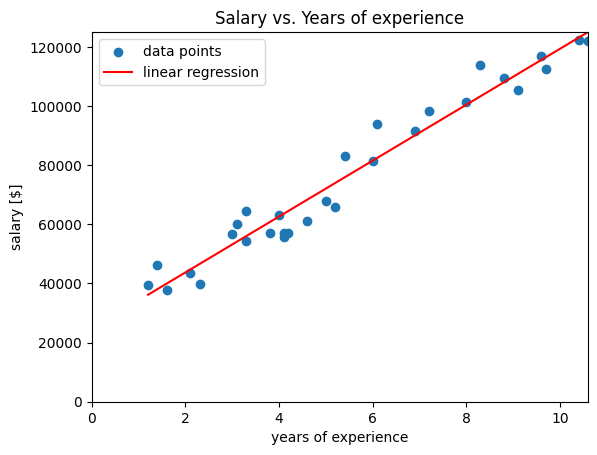

In [5]:
# Plotting data and regression

# Calculate two points at min/max of x-data to plot regression line
def calc_prediction(X, m):
    '''Function calculates y, if X (scalar) is given using model m.
    m has to be scipy.stats.linregress'''
    return m.slope*X + scipy_lin_reg.intercept

# Create data frame holding min/max of X and predicted y
scipy_prediction = pd.DataFrame([[data_salary.years_exp.min(), 
                                  calc_prediction(data_salary.years_exp.min(), scipy_lin_reg)], 
                                 [data_salary.years_exp.max(), 
                                  calc_prediction(data_salary.years_exp.max(), scipy_lin_reg)]], 
                                columns=['X', 'y'])

# Plot data as scatter plot, regression as linear curve
fix, ax = plt.subplots()
ax.scatter(data_salary.years_exp, data_salary.salary, label='data points')
ax.plot(scipy_prediction.X, scipy_prediction.y, color='r', label='linear regression')
ax.legend()
ax.set_ylabel('salary [$]')
ax.set_xlabel('years of experience')
ax.set_ylim(0, calc_prediction(data_salary.years_exp.max(), scipy_lin_reg))
ax.set_xlim(0, data_salary.years_exp.max())
ax.set_title('Salary vs. Years of experience')

## Multilinear regression on Boston Housing dataset

## Load data and data inscpection

In [6]:
# Data set is seperated by white space and contains no header.
col_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
                'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston = pd.read_csv('housing.csv', sep=r'\s+', header=None, names=col_names)

In [25]:
# Any missing values? result: no
print(f'Any missing data?\t {boston.isna().any().any()}')
# Looking at absolutes of correlation of sales prices with features
print('\nAbsolute of correlation with \"MEDV"\n', boston.loc[:, 'CRIM':'LSTAT'].corrwith(boston.MEDV).abs())

Any missing data?	 False

Absolute of correlation with "MEDV"
 CRIM       0.388305
ZN         0.360445
INDUS      0.483725
CHAS       0.175260
NOX        0.427321
RM         0.695360
AGE        0.376955
DIS        0.249929
RAD        0.381626
TAX        0.468536
PTRATIO    0.507787
B          0.333461
LSTAT      0.737663
dtype: float64


All but one values are at least over 0.2, allowing that at least that some correlation exists. Value of "CHAS" is eximend further, because its values are nominal (dichotomous). Point-biserial correlation and p-value is calculated:

In [8]:
pointbiserialr(boston.CHAS, boston.MEDV)

SignificanceResult(statistic=0.1752601771902984, pvalue=7.390623170519672e-05)

Low p-value indicate that hypothysis of uncorrelated truth can be rejected. And consequently this variable will also be used in regression. So, in consequence every variable is used.

In [9]:
# Loop over several train/test-splits to crossvalidate fit
n = 10 #number of loops
boston_regression_results = [] # variable to store results in:
for i in range(n):
    # Create Train/test-split
    X_train, X_test, y_train, y_test = train_test_split(boston.loc[:, 'CRIM':'LSTAT'], boston.MEDV, 
                                                        random_state=np.random.randint(low=0, high=12000))
    # Create model using scikit learn linear regression model
    boston_lin_reg = LinearRegression()
    # Train (fit) model on training data set
    boston_lin_reg.fit(X_train, y_train)
    # Make preduction on test data_set
    boston_prediction = boston_lin_reg.predict(X_test)
    boston_regression_results.append(rmse(boston_prediction, y_test)) # store RMSE in list
    
boston_results = pd.DataFrame(boston_regression_results, columns=['rmse'])
print(f'Multible linear regression results in an error (RMSE) of {boston_results.rmse.mean():.1f} +/- \
{boston_results.rmse.std():.1f}')

Multible linear regression results in an error (RMSE) of 5.1 +/- 0.6


## Train neuronal net to compare with

In [10]:
# transform boston data set to zero mean and unit variance, exclude categorical columns 'CHAS' and target
def transform_boston(df_):
    '''Function takes boston housing data set (as DataFrame) and returns a transformed DataFrame:
    column "CHAS": no transformation (categorical)
    column "MEDV": linear scaling to [0, 1] as it is target'''
    scaler = StandardScaler() # Create instance of standard-scaler
    scaler_minmax = MinMaxScaler() # Create instance of MinMaxScaler to transform target to [0, 1]

    return (pd.DataFrame(scaler.fit_transform(df_),
                         columns=df_.columns.to_list()) # Transform all columns in new DataFrae
            .assign(CHAS=df_.CHAS, # Overwrite "CHAS"-columns as it is categorical and should not be transformed
                    MEDV=scaler_minmax.fit_transform(df_.MEDV.to_numpy()[:, np.newaxis])) # Overwrite
                    # target-column, as it should be transformed with MinMaxScaler
            )

# Apply transformation function
boston_transformed = transform_boston(boston)

In [12]:
# List to store RMSE on training data in
rmse_training = []
# List to store RMSE on test data in
rmse_test = []

# Fit net to different train/test splits
for i in range(10):
    # Get train and test split of transformed data
    X_train, X_test, y_train, y_test = train_test_split(boston_transformed.loc[:, 'CRIM':'LSTAT'], boston.MEDV,
                                                    random_state=np.random.randint(0, 12000))
    # Define net
    net = ks.Sequential()
    net.add(ks.layers.GaussianNoise(0.25, input_shape=(13,))) #Adding Gaussian noise to input for regularzation
    net.add(ks.layers.Dense(20, activation='tanh')) #First hidden layer
    net.add(ks.layers.Dense(1, activation='linear')) # Output layer
    net.compile(optimizer='adam', metrics='RootMeanSquaredError', loss='mean_squared_error') # compile command
    # Fit net to training data set
    history = net.fit(X_train, y_train, batch_size=16, epochs=300, verbose=0)
    # Store last RMSE on training data set
    rmse_training.append(history.history['root_mean_squared_error'][-1])
    # Store RMSE on test data set
    rmse_test.append(net.evaluate(X_test, y_test)[-1]) # Last returned element is RMSE


4/4 [==============================] - 0s 2ms/step - loss: 18.6161 - root_mean_squared_error: 4.3146


In [20]:
# Create DataFrame with observed RMSE on training and test data set
neuronal_net_results = pd.DataFrame({'rmse_training': rmse_training, 'rmse_test': rmse_test})
# Does performance of net significantly decreases from training to test data (overfitting)? 
# This is tested by performing a Welch-test (unlike t-test it doesn't assume equal variance)
# Significance level of alpha = 10 % is chosen
print('Nullhypothesis: RMSE on training and test data are same.')
print('Alternative hypthesis: RMSE on training and test data ware different.\n')
welch_result = ttest_ind(a=neuronal_net_results.rmse_training, b=neuronal_net_results.rmse_test, 
                         equal_var=False)
print(f'Obtained p-value lies above alpha, p-value: {welch_result[-1]:.2f}. Thus Nullhypothesis', 
 f'is accepted.\n'
 f'Previous calculations with lower noise level in first layer of neuronal net showed significant '
 f'differences between training and testing data sets. Hence showing overfitting.')

Nullhypothesis: RMSE on training and test data are same.
Alternative hypthesis: RMSE on training and test data ware different.

Obtained p-value lies above alpha, p-value: 0.28. Thus Nullhypothesis is accepted.
Previous calculations with lower noise level in first layer of neuronal net showed significant differences between training and testing data sets. Hence showing overfitting.


In [23]:
# How well is the net doing?
print(f'The neuronal net achieves an RMSE of {neuronal_net_results.rmse_test.mean():.1f}'
f'+/- {neuronal_net_results.rmse_test.std():.1f}, when evaluated on test data of different'
f'train/test-splits.\n'
f'This is a better performance than those of multible linear regression, while variance of performance\n'
f'is comparable.')

The neuronal net achieves an RMSE of 4.2+/- 0.6, when evaluated on test data of differenttrain/test-splits.
This is a better performance than those of multible linear regression, while variance of performance
is comparable.
